In [12]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import math
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
# model from https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    # per batch stats
    # - losses = loss for batch
    # - time_for_batch = time to proccess batch
    # - params = params during this batch
    # - batch_idx = index of current batch
    
    model.train()
    num_data = 0
    num_updates = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # training step on batch
        start_step_time = time.time()
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        num_data += len(data)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        end_step_time = time.time()
        num_updates += 1
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
     # From train(), only return the number of model updates and the number of data fed into the model
    return num_data, num_updates

In [10]:
def generate_stats(epochs=14):
    
    # params
    device = torch.device("cpu")
    log_interval = 10
    train_kwargs = {'batch_size': 64}
    
    # transform data
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    
    # load data
    dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST('./data', train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    
    # model and optimizer
    model = Net().to(device)
    
    # Seems like adadelta would adjust the learning rate, so why do we need a scheuler?
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

    # set up statistics
    stats = [] # will hold dictionary entries, one per epoch
    statistics = {
        "epoch_times": [], # time for each epoch of training,
        "batch_data_for_epochs": [], # stats for each batch within each epoch
        "total_train_time": 0
    }
    
    for epoch in range(1, epochs + 1):
        # run training
        epoch_start_time = time.time()
        num_data, num_updates = train(model, device, train_loader, optimizer, epoch, log_interval)
        scheduler.step()
        # update stats
        stats = {
            "data_pts_ran": num_data,
            "model_updates": num_updates,
            "epoch_time": time.time() - epoch_start_time,
            "batch_size": 64
        }
    
    return statistics

In [11]:
stats = generate_stats(1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322193
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.741648
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.948552
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.589927
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.407073
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.337465
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.212117
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.279841
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.323731
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.221222
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.260793
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.301912
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.273397
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.125138
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.167160
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.180376
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.364134
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.139102
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.363746
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.113765
Train Epoch: 1 [12800/60000 (

TypeError: cannot unpack non-iterable NoneType object

In [59]:
def print_stats(stats):
    print("Epoch Level Stats:\t", list(stats.keys()))
    print("Batch Level Stats:\t", list(stats['batch_data_for_epochs'][0].keys()))
    print("Epochs Computed:\t", len(stats['batch_data_for_epochs']))
    print("Batches per epoch:\t", len(stats['batch_data_for_epochs'][0]['losses']))
    print("Initial Model Params:\t", stats['initial_params'])
    print("Final Model Params:\t", stats['final_params'])
    print("Time per epoch:\t\t", [round(time, 5) for time in stats['epoch_times']])
print_stats(stats)

Epoch Level Stats:	 ['initial_params', 'final_params', 'epoch_times', 'batch_data_for_epochs', 'total_train_time']
Batch Level Stats:	 ['losses', 'time_for_batch', 'params', 'batch_idx']
Epochs Computed:	 1
Batches per epoch:	 938
Initial Model Params:	 <generator object Module.named_parameters at 0x7f9e750da550>
Final Model Params:	 <generator object Module.named_parameters at 0x7f9e750da5d0>
Time per epoch:		 [120.28852]


In [66]:
epoch1_losses = stats['batch_data_for_epochs'][0]['losses']
epoch1_times = stats['batch_data_for_epochs'][0]['time_for_batch']

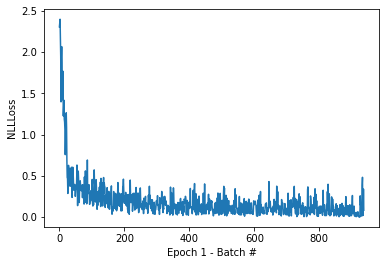

In [65]:
plt.plot(epoch1_losses)
plt.xlabel('Epoch 1 - Batch #')
plt.ylabel('NLLLoss');

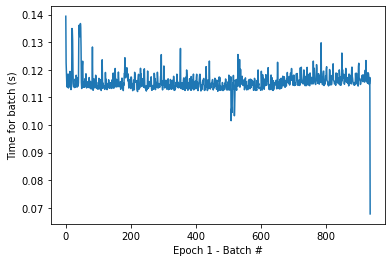

In [69]:
plt.plot(epoch1_times)
plt.xlabel('Epoch 1 - Batch #')
plt.ylabel('Time for batch (s)');